<a href="https://colab.research.google.com/github/fatimakhazaeni/_my_ai_repo/blob/main/autoencoder_denoise_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

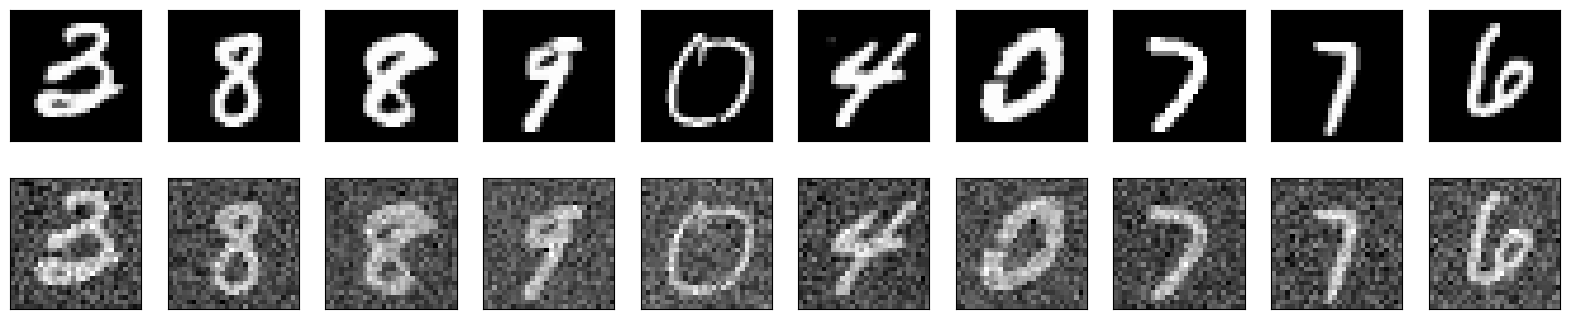

In [10]:
#Autoencoder for image denoising
#Import Library

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
#from tensorflow.keras import layers
#from tensorflow.keras.datasets import mnist
#from tensorflow.keras.models import Model
from keras.models import Sequential
from keras.layers import *
from skimage.io import imread, imshow, imsave

from IPython.display import Image


#Normalizes the supplied array and reshapes it into the appropriate format.


def preprocess(array):
    """
    Normalizes the supplied array and reshapes it into the appropriate format.
    """

    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), 28, 28, 1))
    return array


#NAdds random noise to each image in the supplied array

def apply_gaussian_noise(X, sigma=0.2):
    noise = np.random.normal(loc=0.0, scale=sigma, size=X.shape)
    return X + noise

#Displays ten random images from each one of the supplied arrays


def display(array1, array2):
    """
    Displays ten random images from each one of the supplied arrays.
    """

    n = 10

    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

#Prepare the data

# Since we only need images from the dataset to encode and decode, we
# won't use the labels.
(train_data, y_train), (test_data, y_test) = mnist.load_data()

# Normalize and reshape the data
train_data = preprocess(train_data)
test_data = preprocess(test_data)

# Create a copy of the data with added noise
noisy_train_data = apply_gaussian_noise(train_data)
noisy_test_data = apply_gaussian_noise(test_data)

# Display the train data and a version of it with added noise
display(train_data, noisy_train_data)


In [11]:
#Build the autoencoder
#We are going to use the Functional API to build our convolutional autoencoder.


def build_autoencoder(img_shape, code_size):
    # The encoder
    encoder = Sequential()
    encoder.add(InputLayer(img_shape))
    encoder.add(Flatten())
    encoder.add(Dense(code_size))

    # The decoder
    decoder = Sequential()
    decoder.add(InputLayer((code_size,)))
    decoder.add(Dense(np.prod(img_shape))) # np.prod(img_shape) is the same as 32*32*3, it's more generic than saying 3072
    decoder.add(Reshape(img_shape))

    return encoder, decoder


# Same as (28,28,1), we neglect the number of instances from shape
IMG_SHAPE = train_data.shape[1:]
encoder, decoder = build_autoencoder(IMG_SHAPE, 28)

inp = Input(IMG_SHAPE)
enco = encoder(inp)
deco = decoder(enco)

autoencoder = Model(inp,deco)
autoencoder.compile(optimizer='adamax', loss='mse')

print(autoencoder.summary())


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 sequential_4 (Sequential)   (None, 28)                21980     
                                                                 
 sequential_5 (Sequential)   (None, 28, 28, 1)         22736     
                                                                 
Total params: 44716 (174.67 KB)
Trainable params: 44716 (174.67 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [12]:
history = autoencoder.fit(
    x=train_data,
    y=train_data,
    epochs=20,
    batch_size=128,
    shuffle=True,
    validation_data=(test_data, test_data),


)

Epoch 1/20
469/469 [==============================] - 3s 5ms/step - loss: 0.0464 - val_loss: 0.0293
Epoch 2/20
469/469 [==============================] - 2s 5ms/step - loss: 0.0253 - val_loss: 0.0220
Epoch 3/20
469/469 [==============================] - 3s 6ms/step - loss: 0.0211 - val_loss: 0.0198
Epoch 4/20
469/469 [==============================] - 3s 7ms/step - loss: 0.0199 - val_loss: 0.0191
Epoch 5/20
469/469 [==============================] - 2s 5ms/step - loss: 0.0195 - val_loss: 0.0189
Epoch 6/20
469/469 [==============================] - 2s 5ms/step - loss: 0.0193 - val_loss: 0.0188
Epoch 7/20
469/469 [==============================] - 2s 5ms/step - loss: 0.0193 - val_loss: 0.0187
Epoch 8/20
469/469 [==============================] - 2s 5ms/step - loss: 0.0192 - val_loss: 0.0187
Epoch 9/20
469/469 [==============================] - 4s 8ms/step - loss: 0.0192 - val_loss: 0.0187
Epoch 10/20
469/469 [==============================] - 2s 5ms/step - loss: 0.0192 - val_loss: 0.0187

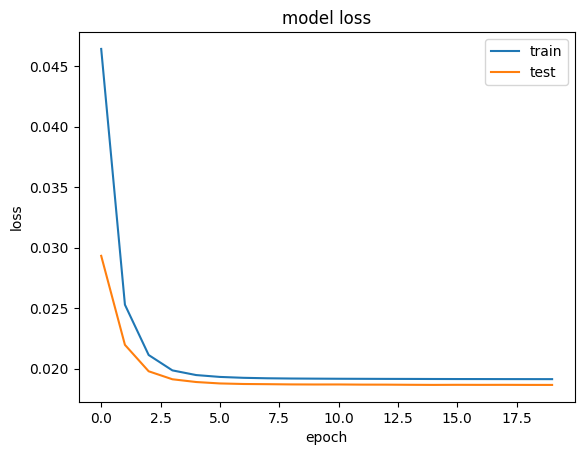

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

1/1 [==============================] - 0s 51ms/step


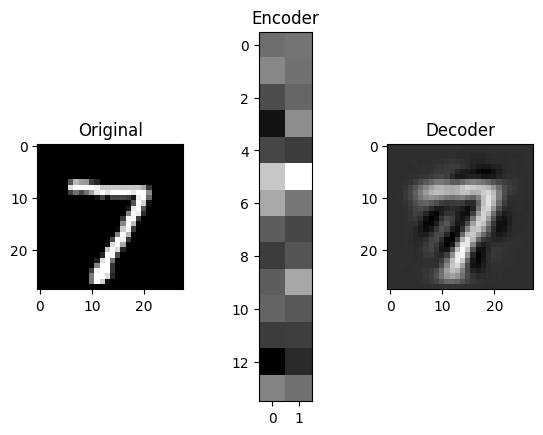

1/1 [==============================] - 0s 24ms/step


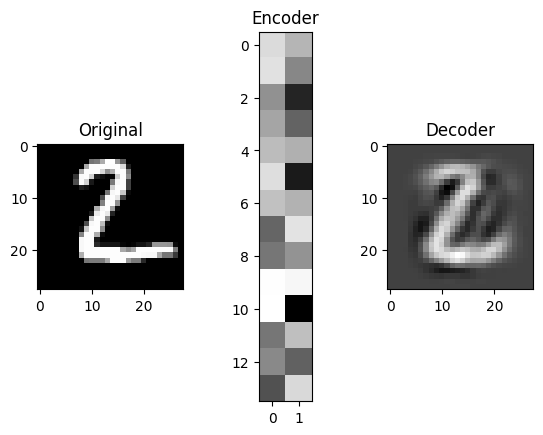

1/1 [==============================] - 0s 25ms/step


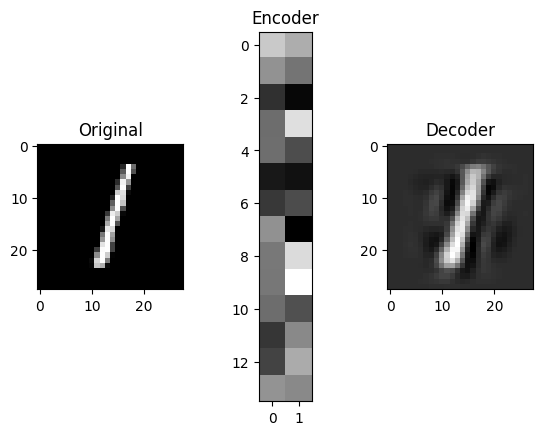

1/1 [==============================] - 0s 20ms/step


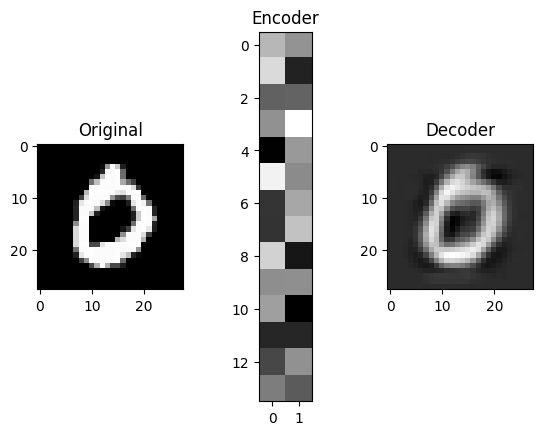

1/1 [==============================] - 0s 19ms/step


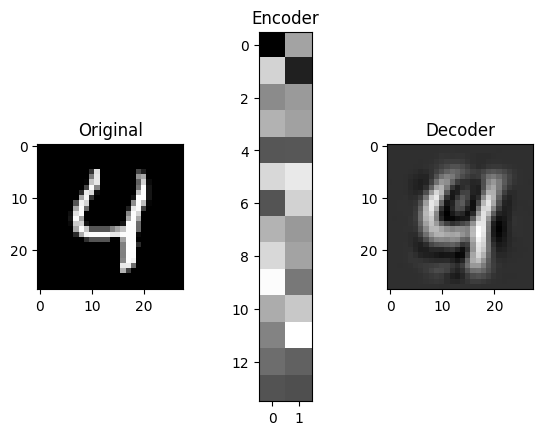

In [14]:
def visualize(img,encoder,decoder):
    """Draws original, encoded and decoded images"""
    # img[None] will have shape of (1, 28, 28, 1) which is the same as the model input
    enco = encoder.predict(img[None])[0]
    deco = decoder.predict(enco[None])[0]

    plt.subplot(1,3,1)
    plt.title("Original")
    plt.imshow(img)

    plt.subplot(1,3,2)
    plt.title("Encoder")
    plt.imshow(enco.reshape([enco.shape[-1]//2,-1]))

    plt.subplot(1,3,3)
    plt.title("Decoder")
    plt.imshow(deco)
    plt.show()

for i in range(5):
    img = test_data[i]
    visualize(img,encoder,decoder)


In [15]:
# We can use bigger code size for better quality
encoder, decoder = build_autoencoder(IMG_SHAPE, 28)

inp = Input(IMG_SHAPE)
enco = encoder(inp)
deco = decoder(enco)

autoencoder = Model(inp, deco)
autoencoder.compile('adamax', 'mse')

    # We continue to train our model with new noise-augmented data
autoencoder.fit(x=noisy_train_data, y=train_data, epochs=10,
                    validation_data=[noisy_test_data, test_data])

Epoch 1/10
1875/1875 [==============================] - 7s 3ms/step - loss: 0.0326 - val_loss: 0.0210
Epoch 2/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0209 - val_loss: 0.0203
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0207 - val_loss: 0.0202
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0206 - val_loss: 0.0202
Epoch 5/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0206 - val_loss: 0.0202
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0206 - val_loss: 0.0202
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0206 - val_loss: 0.0202
Epoch 8/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0206 - val_loss: 0.0202
Epoch 9/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0206 - val_loss: 0.0201
Epoch 10/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.020

1/1 [==============================] - 0s 55ms/step


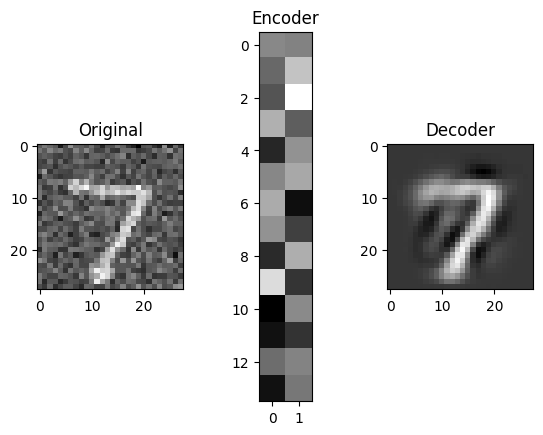

1/1 [==============================] - 0s 23ms/step


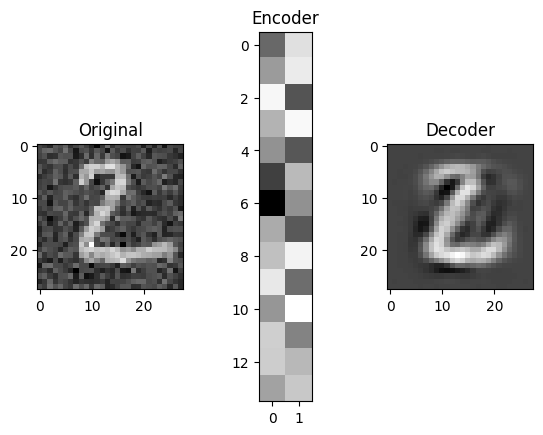

1/1 [==============================] - 0s 29ms/step


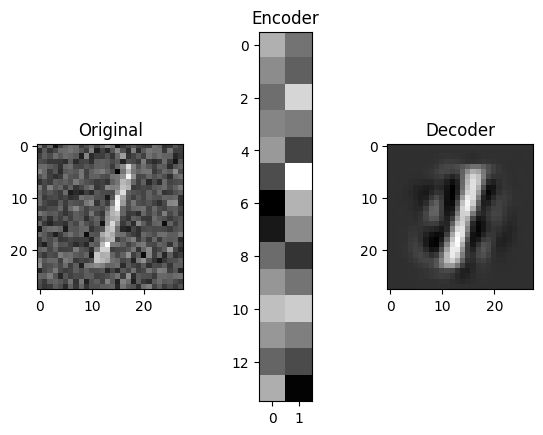

1/1 [==============================] - 0s 30ms/step


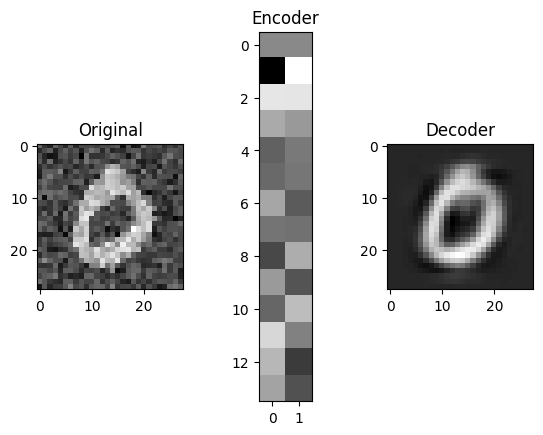

1/1 [==============================] - 0s 30ms/step


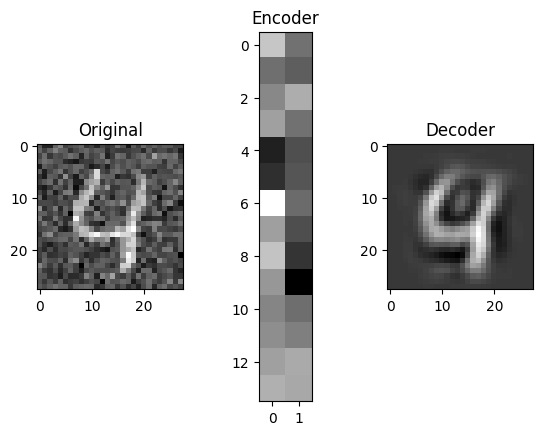

In [16]:
X_test_noise = apply_gaussian_noise(test_data)
for i in range(5):
    img = X_test_noise[i]
    visualize(img,encoder,decoder)